## Image Classification
* Dataset: the Oxford Flowers 102 (instead of the tf_flowers dataset)
* Base model: MobileNet v2 from TensorFlow Hub (instead of tf.keras.applications)


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
import tensorflow as tf

tfds.disable_progress_bar()
tf.__version__

'2.13.0'

In [3]:
# Tensorflow hub
import tensorflow_hub as hub

### Data Pipeline

OxFord Flowers 102 is one of the TensorFlow 2.0 datasets with 102 category of common flowers in UK.

In [4]:
(raw_train, raw_validation, raw_test), metadata = tfds.load(
    name="oxford_flowers102",
    split=['train', 'validation', 'test'],
    with_info = True,
    as_supervised=True
)

Dataset oxford_flowers102 downloaded and prepared to /root/tensorflow_datasets/oxford_flowers102/2.1.1. Subsequent calls will reuse this data.


In [5]:
num_classes = metadata.features['label'].num_classes
num_train =  len(list(raw_train))
num_validation = len(list(raw_validation))
num_test = len(list(raw_test))

print("Number of classes:", num_classes)
print("Number of training samples:", num_train)
print("Number of validation samples:",  num_validation)
print("Number of test samples:", num_test)

Number of classes: 102
Number of training samples: 1020
Number of validation samples: 1020
Number of test samples: 6149


In [6]:
# Inspect datasets before data preprocessing
print(raw_train)
print(raw_validation)
print(raw_test)

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>
<_PrefetchDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>
<_PrefetchDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>


In [7]:
classlabel = metadata.features['label']
classlabel.get_serialized_info

<bound method Tensor.get_serialized_info of ClassLabel(shape=(), dtype=int64, num_classes=102)>

In [8]:
# Get labels / class names
class_names = np.array(metadata.features['label'].names)
class_names

array(['pink primrose', 'hard-leaved pocket orchid', 'canterbury bells',
       'sweet pea', 'english marigold', 'tiger lily', 'moon orchid',
       'bird of paradise', 'monkshood', 'globe thistle', 'snapdragon',
       "colt's foot", 'king protea', 'spear thistle', 'yellow iris',
       'globe-flower', 'purple coneflower', 'peruvian lily',
       'balloon flower', 'giant white arum lily', 'fire lily',
       'pincushion flower', 'fritillary', 'red ginger', 'grape hyacinth',
       'corn poppy', 'prince of wales feathers', 'stemless gentian',
       'artichoke', 'sweet william', 'carnation', 'garden phlox',
       'love in the mist', 'mexican aster', 'alpine sea holly',
       'ruby-lipped cattleya', 'cape flower', 'great masterwort',
       'siam tulip', 'lenten rose', 'barbeton daisy', 'daffodil',
       'sword lily', 'poinsettia', 'bolero deep blue', 'wallflower',
       'marigold', 'buttercup', 'oxeye daisy', 'common dandelion',
       'petunia', 'wild pansy', 'primula', 'sunflower

### Visualize the data

See how our data looks like (2 images)

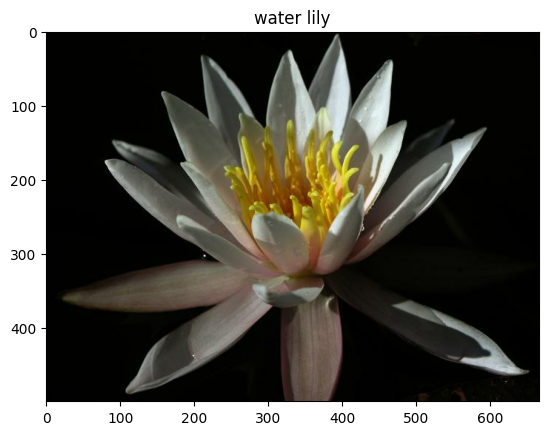

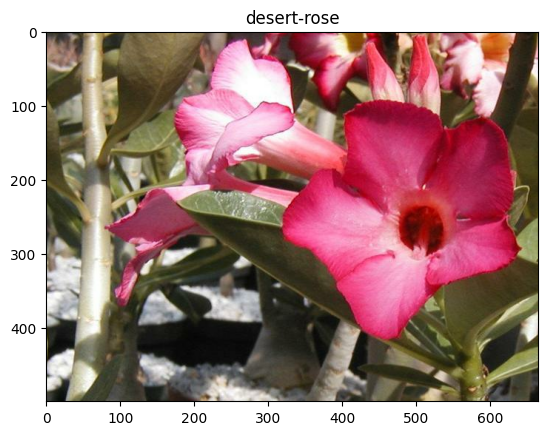

In [9]:
for image, label in raw_train.take(2):
  plt.figure()
  plt.imshow(image)
  plt.title(class_names[label])

### Data Preprocessing

* convert img to tensor(float32)
* resize image
* normalize the image
* agument images (only in training set)
* shuffle and create batches

In [10]:
IMG_SIZE = 224
IMG_SHAPE = (IMG_SIZE, IMG_SIZE, 3)

def format_example(image, label):
  image = tf.cast(image, tf.float32)
  image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
  image = image/255.0
  return image, label

In [11]:
train = raw_train.map(format_example)
validation = raw_validation.map(format_example)
test = raw_test.map(format_example)

In [12]:
def augment_data(image, label):
  image = tf.image.random_flip_left_right(image)
  image = tf.image.random_contrast(image, lower=0.0, upper=1.0)
  image = tf.stack(image, axis=0)
  image = tf.image.random_crop(image, size=[IMG_SIZE, IMG_SIZE, 3])
  return image, label

In [13]:
train = train.map(augment_data)

In [14]:
# shuffling and making batches
BATCH_SIZE = 32
SHUFFLE_BUFFER_SIZE = 1000

train_batches = train.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE).repeat()
validation_batches = validation.batch(BATCH_SIZE).repeat()
test_batches = test.batch(BATCH_SIZE)

In [15]:
# Datasets after prepreocssing
print(train_batches)
print(validation_batches)
print(test_batches)

<_RepeatDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>
<_RepeatDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>
<_BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>


In [16]:
# Finding shape of input tensor
for image_batch, label_batch in train_batches.take(1):
   pass

image_batch.shape

TensorShape([32, 224, 224, 3])

### Building the model

In [17]:
feature_extractor_url = "https://tfhub.dev/google/imagenet/mobilenet_v2_100_224/feature_vector/4"
feature_extractor_layer = hub.KerasLayer(feature_extractor_url, input_shape = IMG_SHAPE, trainable=False)

In [18]:
model = tf.keras.Sequential([
    feature_extractor_layer,
    tf.keras.layers.Dense(num_classes, activation="softmax")
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 1280)              2257984   
                                                                 
 dense (Dense)               (None, 102)               130662    
                                                                 
Total params: 2388646 (9.11 MB)
Trainable params: 130662 (510.40 KB)
Non-trainable params: 2257984 (8.61 MB)
_________________________________________________________________


In [19]:
# compile the model
model.compile(
    loss=tf.keras.losses.sparse_categorical_crossentropy,
    optimizer=tf.keras.optimizers.Adam(),
    metrics=["accuracy"]
)

In [20]:
# Set training parameters
NUM_EPOCHS = 10
steps_per_epoch = round(num_train)//BATCH_SIZE
validation_steps = round(num_validation)//BATCH_SIZE

In [21]:
# fit on training set
history = model.fit(train_batches,
                    epochs=NUM_EPOCHS,
                    steps_per_epoch=steps_per_epoch,
                    validation_data=validation_batches,
                    validation_steps=validation_steps)

Epoch 1/10
31/31 [==============================] - 23s 252ms/step - loss: 4.5243 - accuracy: 0.0847 - val_loss: 3.3418 - val_accuracy: 0.2984
Epoch 2/10
31/31 [==============================] - 9s 210ms/step - loss: 2.7376 - accuracy: 0.4787 - val_loss: 2.3519 - val_accuracy: 0.5625
Epoch 3/10
31/31 [==============================] - 8s 266ms/step - loss: 1.8658 - accuracy: 0.6761 - val_loss: 1.8552 - val_accuracy: 0.6492
Epoch 4/10
31/31 [==============================] - 7s 221ms/step - loss: 1.3151 - accuracy: 0.8077 - val_loss: 1.5410 - val_accuracy: 0.7288
Epoch 5/10
31/31 [==============================] - 7s 216ms/step - loss: 1.1056 - accuracy: 0.8158 - val_loss: 1.3545 - val_accuracy: 0.7319
Epoch 6/10
31/31 [==============================] - 6s 189ms/step - loss: 0.8765 - accuracy: 0.8755 - val_loss: 1.2208 - val_accuracy: 0.7681
Epoch 7/10
31/31 [==============================] - 6s 214ms/step - loss: 0.7651 - accuracy: 0.8947 - val_loss: 1.1346 - val_accuracy: 0.7792
Epoch

In [25]:
# Display training curves
def display_training_curves(history, title):
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']

  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs_range = range(NUM_EPOCHS)

  plt.plot(epochs_range, acc, label='Train accuracy')
  plt.plot(epochs_range, val_acc, label='Val accuracy')
  plt.title(title)
  plt.legend(loc='upper left')
  plt.figure()

  plt.show();

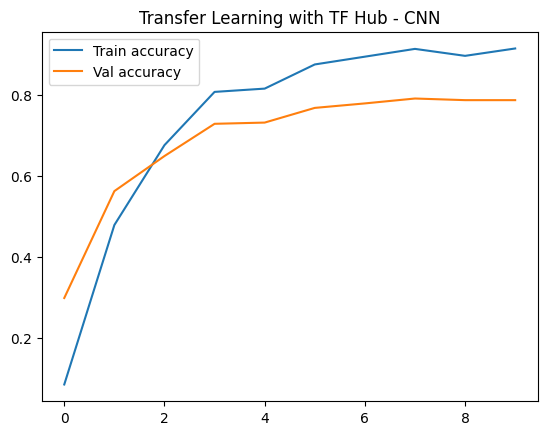

<Figure size 640x480 with 0 Axes>

In [26]:
# Display training curve
display_training_curves(history, "Transfer Learning with TF Hub - CNN")

In [23]:
# Evaluate the model on the test dataset
score = model.evaluate(test_batches, verbose=0)

# Print test accuracy
print('\n', 'Test accuracy:', score[1])


 Test accuracy: 0.7510164380073547


Visualize the predictions

In [24]:
image_batch, label_batch = next(iter(test_batches))

image_batch = image_batch.numpy()
label_batch = label_batch.numpy()

predicted_batch = model.predict(image_batch)
predicted_batch = tf.squeeze(predicted_batch).numpy()

predicted_class_ids = np.argmax(predicted_batch, axis=-1)
predicted_class_names = class_names[predicted_class_ids]

1/1 [==============================] - 1s 553ms/step


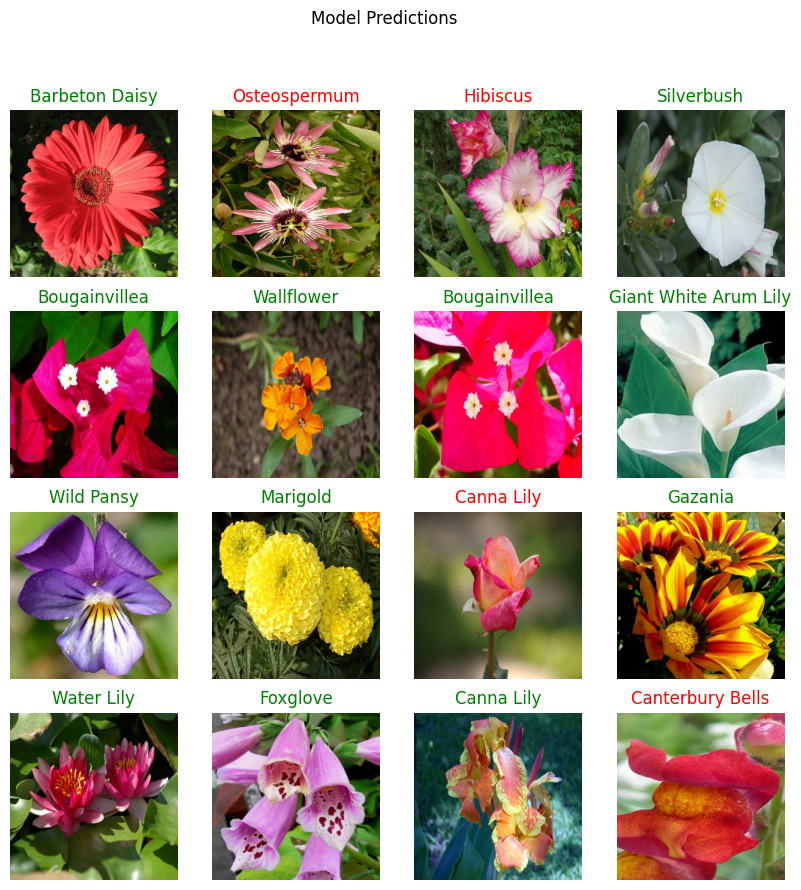

In [27]:
plt.figure(figsize=(10, 10))

# Display 16 test images with predictions
for i in range(16):
  plt.subplot(4, 4, i+1)
  # Display each image
  plt.imshow(image_batch[i])
  # Set title color: green if prediction correct and red if prediction incorrect
  title_color = "green" if predicted_class_ids[i] == label_batch[i] else "red"
  plt.title(predicted_class_names[i].title(), color=title_color)
  plt.axis('off')

_ = plt.suptitle("Model Predictions")